# Analysing mybinder.org launches

The first few cells download and massage the data. Later on we answer questions on which repositories are popular and such.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import datetime

import pandas as pd

In [2]:
index = pd.read_json("https://archive.analytics.mybinder.org/index.jsonl",
                     lines=True)

In [3]:
# get all days since start of 2019
now = datetime.datetime.now()
n = (now - datetime.datetime(2019, 1, 1)).days

frames = []
for idx, day in index.sort_index(ascending=False).iterrows():
    df = pd.read_json("https://archive.analytics.mybinder.org/{}".format(day['name']),
                      lines=True, )
    frames.append(df)
    if len(frames) > n:
        break
        
print(f"Fetched data for {n} days.")

Fetched data for 114 days.


In [4]:
df = pd.concat(frames)

In [5]:
# make it easier to grab the ref
df['repo'] = df['spec'].apply(lambda s: s.rsplit("/", 1)[0])
df['org'] = df['spec'].apply(lambda s: s.split("/", 1)[0])
df['ref'] = df['spec'].apply(lambda s: s.rsplit("/", 1)[1])

In [16]:
# take a look at the data, does it look sensible?
df.sample(10)

,provider,status,timestamp,repo,org,ref
9842,GitHub,success,2019-03-20 15:36:00,ipython/ipython-in-depth,ipython,master
5401,GitHub,success,2019-03-11 10:11:00,ipython/ipython-in-depth,ipython,master
8072,GitHub,success,2019-03-21 13:57:00,ipython/ipython-in-depth,ipython,master
13344,GitHub,success,2019-03-04 17:58:00,ipython/ipython-in-depth,ipython,master
5163,GitHub,success,2019-01-29 09:10:00,ipython/ipython-in-depth,ipython,master
9281,GitHub,success,2019-01-14 16:19:00,jupyterlab/jupyterlab-demo,jupyterlab,master
11398,GitHub,success,2019-03-05 14:18:00,NumEconCopenhagen/exercises-2019,NumEconCopenhagen,master
12491,GitHub,success,2019-03-08 22:02:00,jupyterlab/jupyterlab-demo,jupyterlab,master
6721,GitHub,success,2019-04-17 11:39:00,ipython/ipython-in-depth,ipython,master
2765,GitHub,success,2019-01-06 11:50:00,ipython/ipython-in-depth,ipython,master


In [7]:
df = df.drop(columns=['schema', 'version', 'spec'])

In [8]:
df.head()

,provider,status,timestamp,repo,org,ref
0,GitHub,success,2019-04-25,jswortz/UIC_Clustering_Code_2019,jswortz,master
1,GitHub,success,2019-04-25,jswortz/UIC_Clustering_Code_2019,jswortz,master
2,GitHub,success,2019-04-25,jswortz/UIC_Clustering_Code_2019,jswortz,master
3,GitHub,success,2019-04-25,abraham314/dataproy,abraham314,master
4,GitHub,success,2019-04-25,jswortz/UIC_Clustering_Code_2019,jswortz,master


## Total launches

In [9]:
# Sneak peek: total launches!
df.shape

(1528796, 6)

In [10]:
# add a nnew column showing total launches per repo
totals_per_repo = (df.groupby(["repo"])
 .size()
 .reset_index(name='repo_counts'))

In [11]:
# add a nnew column showing total launches per org
totals_per_org = (df.groupby(["org"])
 .size()
 .reset_index(name='org_counts'))

In [12]:
df_ = pd.merge(df, totals_per_repo, on='repo')
df_ = pd.merge(df_, totals_per_org, on='org')
#df_.sample(10)

## Launches per day

In [26]:
daily = df.set_index("timestamp").resample('D').count()

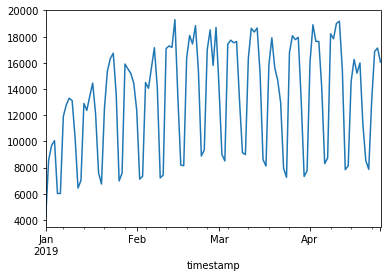

In [27]:
daily['repo'].plot()

## Estimate number of unique repositories

Expect the raw number of launches to be bigger than the number of repositories launched more than once. Those launched only once might have been accidents.

In [13]:
len(set(df.repo))

7295

In [14]:
len(set(df_.repo[df_.repo_counts>1]))

4841

## Where are repositories hosted?

In [15]:
(df.groupby("provider")
   .size()
   .reset_index(name='Launches')
   .sort_values('Launches', ascending=False))

,provider,Launches
1,GitHub,750792
2,GitLab,2709
0,Git,472


## Popular repositories and their branches

In [16]:
(df_.groupby(["org", "repo", "ref", "repo_counts", "org_counts"])
 .size()
 # give the column a nice name
 .reset_index(name='ref_counts')
 # sort first by total launches, then within a repo by ref launches
 .sort_values(['org_counts', 'repo_counts', 'ref_counts'],
              ascending=[False,False, False])
 .set_index(["org", 'repo', 'ref'])
)

repo_counts  \
org             repo                                            ref                                                     
ipython         ipython/ipython-in-depth                        master                                         355781   
                ipython/ipython                                 6.x                                               543   
                                                                master                                            543   
                                                                1.x                                               543   
                                                                2.x                                               543   
                ipython/ipyparallel                             master                                              2   
                ipython/ipynb                                   master                                              1   
                ipython/ipython.git                             master                                              1   
                ipython/ipywidgets                              master                                              1   
jupyterlab      jupyterlab/jupyterlab-demo                      master                                          86744   
                                                                18a9793b58ba86660b5ab964e1aeaf7324d667c8        86744   
                jupyterlab/jupyterlab-git                       master                                             42   
                jupyterlab/jupyter-renderers                    master                                             23   
                jupyterlab/jupyterlab-latex                     master                                             22   
                jupyterlab/jupyterlab                           master                                              6   
                jupyterlab/jupyterlab-shortcutui                master                                              3   
                jupyterlab/jupyterlab-demo.git                  master                                              1   
ines            ines/spacy-io-binder                            live                                            30287   
                                                                master                                          30287   
                                                                nightly                                         30287   
DS-100          DS-100/textbook                                 master                                          29766   
binder-examples binder-examples/r                               master                                          13568   
                                                                example                                         13568   
                binder-examples/julia-python                    master                                           5135   
                binder-examples/requirements                    master                                           2514   
                                                                082b794                                          2514   
                binder-examples/jupyter-stacks                  master                                           1135   
                binder-examples/jupyter-sos                     master                                            248   
                                                                python-r                                          248   
                binder-examples/jupyterlab                      master                                            154   
...                                                                                                               ...   
yankev          yankev/test                                     master                                           